<a href="https://colab.research.google.com/github/CS22M105/face_detection_sir/blob/master/Another_copy_of_group_photo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment code with binary

In [3]:
import torch
import csv
import cv2
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

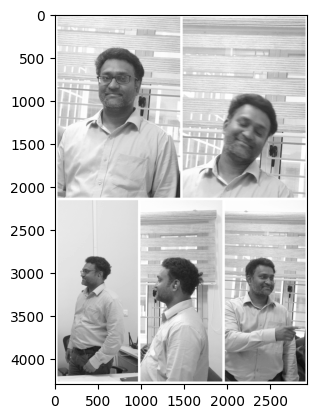

In [4]:
image_path = "/content/kaliSir.jpg"
# cv2 reads image as numpy array
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap="gray")
# gr = transforms.functional.rgb_to_grayscale(image)
# plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
# plt.imshow(gr.squeeze(0).squeeze(0).detach().numpy(), cmap='gray')

after binarizing the input

In [5]:
# Input the binary image
image_path = "/content/BinaryKaliSir.jpg"
# cv2 reads image as numpy array
b_image = cv2.imread(image_path)
gray_image = cv2.cvtColor(b_image, cv2.COLOR_BGR2GRAY)

In [6]:
b_cropped_images = []
def get_filters(xmin, xmax, ymin, ymax):
    b_cropped_images.append(gray_image[ymin:ymax, xmin:xmax])

In [7]:
# Read from csv file
df = pd.read_csv("/content/Kalidas_Sir-export.csv")
for row in df.itertuples(index=False):
    label = row.image
    xmin = int(row.xmin)
    xmax = int(row.xmax)
    ymin = int(row.ymin)
    ymax = int(row.ymax)
    get_filters(xmin, xmax, ymin, ymax)

In [8]:
for i in range(len(b_cropped_images)):
    print(b_cropped_images[i].shape)

(771, 601)
(835, 665)
(412, 378)
(553, 563)
(490, 369)


Text(0.5, 1.0, 'Binary image')

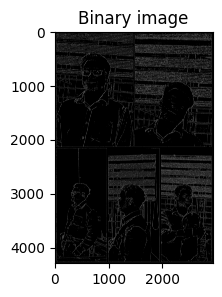

In [9]:
# Visualize the images
plt.figure(figsize=(6, 3))
plt.imshow(cv2.cvtColor(gray_image, cv2.COLOR_BGR2RGB))
plt.title("Binary image")

Text(0.5, 1.0, 'Cropped binary image')

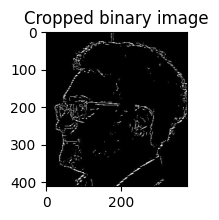

In [10]:
# Visualize the images
plt.figure(figsize=(3, 2))
plt.imshow(cv2.cvtColor(b_cropped_images[2], cv2.COLOR_BGR2RGB))
plt.title("Cropped binary image")

In [11]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [12]:
# pattern_tensor = transform(b_cropped_image)
image = transform(gray_image)

In [13]:
patterns = []
anti_patterns = []
for i in range(len(b_cropped_images)):
    p = transform(b_cropped_images[i])
    a_p = 1 - p
    patterns.append(p)
    anti_patterns.append(a_p)

In [14]:
# batch_size, channel, height, width = tensor.shape
# _, height, width = p.shape
_, i_h, i_w = image.shape

In [ ]:
res = p * ap
temp = torch.nonzero(res)
temp

tensor([], size=(0, 3), dtype=torch.int64)

In [15]:
image.view(1, 1, i_h, i_w).shape

torch.Size([1, 1, 4293, 2930])

In [16]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def convolution(filter_param):
    _, height, weight = filter_param.shape
    p = filter_param.to(device).view(1,1,height,weight)
    return nn.functional.conv2d(image.to(device).view(1,1,i_h,i_w), p, padding='same')


filter_params = [nn.Parameter(filter.to(device)) for filter in patterns]
anti_filter_params = [nn.Parameter(filter.to(device)) for filter in anti_patterns]

all_x_p = []
for filter_param in filter_params:
    x_p = convolution(filter_param)
    all_x_p.append(x_p)

combined_xp = torch.cat(all_x_p, dim=1)

all_x_ap = []
for filter_param in anti_filter_params:
    x_ap = convolution(filter_param)
    all_x_ap.append(x_ap)

combined_xap = torch.cat(all_x_ap, dim=1)


<ipython-input-17-c56fd981a514>:10: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return nn.functional.conv2d(image.to(device).view(1,1,i_h,i_w), p, padding='same')


In [41]:
subtract = combined_xp - combined_xap

In [40]:
# Keep non-negative values only

x_nz = torch.where(subtract > 0.0, subtract, torch.tensor(0.0))
print(x_nz.shape)

torch.Size([1, 5, 4293, 2930])


In [23]:
# Do multiplication of x_nz with x_p_minus_x_np
x3 = x_nz * subtract

In [24]:
# torch.nonzero gives tensor as output

nz_tensor = torch.nonzero(x3)
nz_tensor[:5]

tensor([[   0,    0,  768,  740],
        [   0,    0,  768,  741],
        [   0,    0,  768,  742],
        [   0,    1, 1338, 2247],
        [   0,    1, 1338, 2248]], device='cuda:0')

In [26]:
# Make the list of the values of these indices

nz_values = []
for point in range(len(nz_tensor)):
    x = nz_tensor[point][2].item()
    y = nz_tensor[point][3].item()
    nz_values.append(subtract[0][0][x][y].item())

In [27]:
# Calculate mean and standard deviation
mu = np.mean(nz_values)
sd = np.std(nz_values)
print("mean=",mu)
print("standard deviation=",sd)

mean= -7301.638753255208
standard deviation= 11126.37441149195


In [28]:
# Threshold
th = mu + sd
print("threshold=", th)

threshold= 3824.735658236742


In [29]:
x4 = torch.where(x3 > th, x3, torch.tensor(0.0))

In [30]:
# Get max index
indices = torch.nonzero(x4)
print(indices)

tensor([[   0,    0,  768,  740],
        [   0,    0,  768,  741],
        [   0,    0,  768,  742],
        [   0,    1, 1338, 2247],
        [   0,    1, 1338, 2248],
        [   0,    1, 1338, 2249],
        [   0,    2, 2989,  458],
        [   0,    2, 2989,  459],
        [   0,    2, 2989,  460],
        [   0,    3, 3104, 1410],
        [   0,    3, 3104, 1411],
        [   0,    3, 3104, 1412],
        [   0,    4, 3062, 2385],
        [   0,    4, 3062, 2386],
        [   0,    4, 3062, 2387]], device='cuda:0')


In [38]:
rgb_path = "/content/kaliSir.jpg"
rgb_image = cv2.imread(rgb_path)
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# height, width, _ = cropped_image.shape
height, width = 771, 681

#  Red color box
for point in range(len(indices)):
    xmin = indices[point][2].item()
    ymin = indices[point][3].item()

    # top left corner
    top_x = xmin - height//2
    top_y = ymin - width//2
    top_point = (top_y, top_x)

    # bottom right corner
    bottom_x = xmin + height//2
    bottom_y = ymin + width//2
    bottom_point = (bottom_y, bottom_x)

    image = cv2.rectangle(rgb_image, top_point, bottom_point, (0, 0, 255), 4)
    # image = cv2.rectangle(rgb_image, points, (ymin + width, xmin + height), (0, 0, 255), 1)


# xmin2 = coordinates[12][1].item()
# ymin2 = coordinates[12][0].item()
# points = (xmin2, ymin2)
# image = cv2.rectangle(image, points, (xmin2 + width, ymin2 + height), (0, 0, 255), 1)

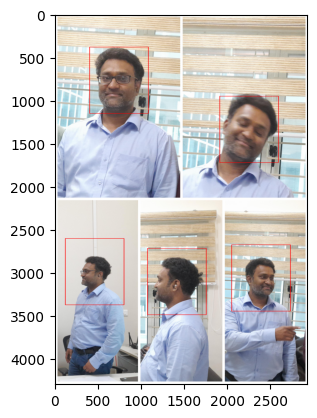

In [39]:
plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
def draw_box(image, coordinate, width, height, color, thickness=1):
    top_left = coordinate
    bottom_right = (top_left[0] + width, top_left[1] + height)
    cv2.rectangle(image, top_left, bottom_right, color, thickness)
    return image

# Experiment code

In [ ]:
import torch
import csv
import cv2
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

In [ ]:
# Read from csv file
df = pd.read_csv("/content/photo-export.csv")
for row in df.itertuples(index=False):
    label = row.image
    xmin = int(row.xmin)
    xmax = int(row.xmax)
    ymin = int(row.ymin)
    ymax = int(row.ymax)

In [ ]:
image_path = "/content/groupPhoto.jpg"
# cv2 reads image as numpy array
image = cv2.imread(image_path)
cropped_image = image[ymin:ymax, xmin:xmax]
print("Cropped image size: ", cropped_image.shape)
print("Original image size: ", image.shape)

Cropped image size:  (92, 68, 3)
Original image size:  (408, 612, 3)


Text(0.5, 1.0, 'Original image')

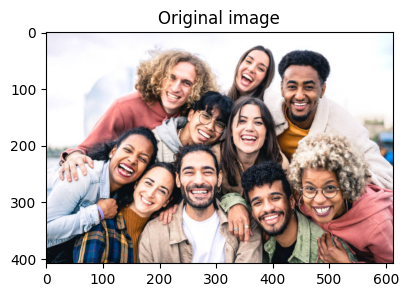

In [ ]:
# Visualize the images
plt.figure(figsize=(6, 3))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original image")

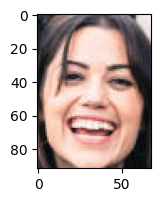

In [ ]:
plt.figure(figsize=(3, 2))
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

(92, 68, 3)


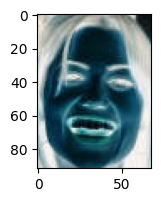

In [ ]:
tmp = cropped_image
tmp = tmp/255
print(tmp.shape)
tmp = 1 - tmp
tmp = tmp.astype('float32')
plt.figure(figsize=(3, 2))
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
tensor_image = transform(cropped_image)
image = transform(image)

In [ ]:
# Normalize the tensor
p = tensor_image.float() / 255.0
ap = 1 - p
image = image.float() / 255.0

In [ ]:
print(type(image))
print(p[1][32][32])
print(ap[1][32][32])

<class 'torch.Tensor'>
tensor(0.0030)
tensor(0.9970)


In [ ]:
p.size()

torch.Size([3, 92, 68])

In [ ]:
ap.size()

torch.Size([3, 92, 68])

In [ ]:
p[0][0]

tensor([0.0014, 0.0012, 0.0009, 0.0008, 0.0012, 0.0011, 0.0007, 0.0005, 0.0005,
        0.0005, 0.0006, 0.0012, 0.0015, 0.0018, 0.0018, 0.0019, 0.0020, 0.0021,
        0.0021, 0.0019, 0.0023, 0.0026, 0.0024, 0.0020, 0.0018, 0.0018, 0.0018,
        0.0020, 0.0020, 0.0021, 0.0020, 0.0018, 0.0016, 0.0014, 0.0014, 0.0014,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0010, 0.0010, 0.0012, 0.0013, 0.0017,
        0.0018, 0.0019, 0.0021, 0.0020, 0.0021, 0.0026, 0.0022, 0.0024, 0.0021,
        0.0015, 0.0008, 0.0005, 0.0007, 0.0012, 0.0030, 0.0034, 0.0037, 0.0036,
        0.0037, 0.0036, 0.0036, 0.0037, 0.0036])

In [ ]:
ap[0][0]

tensor([0.9986, 0.9988, 0.9991, 0.9992, 0.9988, 0.9989, 0.9993, 0.9995, 0.9995,
        0.9995, 0.9994, 0.9988, 0.9985, 0.9982, 0.9982, 0.9981, 0.9980, 0.9979,
        0.9979, 0.9981, 0.9977, 0.9974, 0.9976, 0.9980, 0.9982, 0.9982, 0.9982,
        0.9980, 0.9980, 0.9979, 0.9980, 0.9982, 0.9984, 0.9986, 0.9986, 0.9986,
        0.9988, 0.9988, 0.9988, 0.9988, 0.9990, 0.9990, 0.9988, 0.9987, 0.9983,
        0.9982, 0.9981, 0.9979, 0.9980, 0.9979, 0.9974, 0.9978, 0.9976, 0.9979,
        0.9985, 0.9992, 0.9995, 0.9993, 0.9988, 0.9970, 0.9966, 0.9963, 0.9964,
        0.9963, 0.9964, 0.9964, 0.9963, 0.9964])

In [ ]:
# batch_size, channel, height, width = tensor.shape
_, height, width = p.shape

In [ ]:
# # Applying a conv2d layer(nn.conv2d is derivative type)
# conv_layer1 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(height, width), stride=1, padding=1)
# conv_layer2 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(height, width), stride=1, padding=1)
# pool = nn.MaxPool2d(25, stride=1, padding=12)
# # manual intialization of weight(filter) with a face image
# conv_layer1.weight.data = p.view(1, 3, height, width)
# conv_layer2.weight.data = ap.view(1, 3, height, width)
# x_p = conv_layer1(image)
# x_ap = conv_layer2(image)
conv_layer2 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(height, width), stride=1, padding=1)
conv_layer2.weight.data = ap.view(1, 3, height, width)
temp = conv_layer2(p)
temp

tensor([[[40.7898, 41.1042, 40.8863],
         [41.0716, 41.3879, 41.1669],
         [40.7163, 41.0216, 40.8044]]], grad_fn=<SqueezeBackward1>)

In [ ]:
i_c, i_h, i_w = image.shape
image.view(1,i_c,i_h,i_w).shape

torch.Size([1, 3, 408, 612])

In [ ]:
# apply nn.functional.conv2d (it is non derivative type)
p_weights = p.view(1, 3, height, width)
ap_weights = ap.view(1, 3, height, width)
x_p = F.conv2d(image.view(1,i_c,i_h,i_w), weight=p_weights, padding=1)
x_ap = F.conv2d(image.view(1,i_c,i_h,i_w), weight=ap_weights, padding=1)
# pool = nn.MaxPool2d(25, stride=1, padding=12)

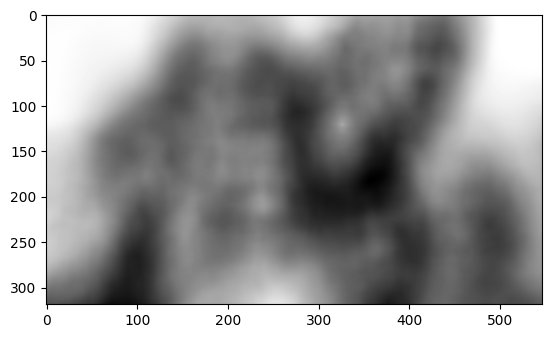

In [ ]:
# after conv layer 1
plt.imshow(x_p.squeeze(0).squeeze(0).detach().numpy(), cmap='gray')
plt.show()

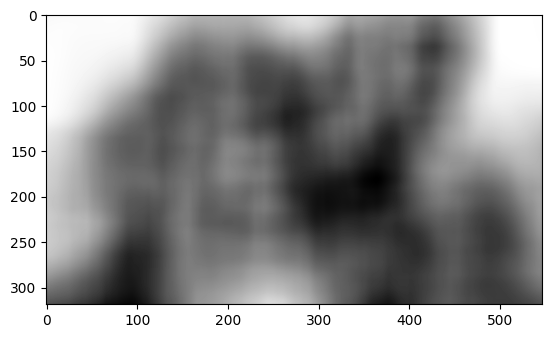

In [ ]:
#  after conv layer 2
plt.imshow(x_ap.squeeze(0).squeeze(0).detach().numpy(), cmap='gray')
plt.show()

In [ ]:
# Conv_Pattern output - conv_Anti_Pattern output
x_p_minus_x_ap = x_p - x_ap
# after_maxpooling = pool(contrast)

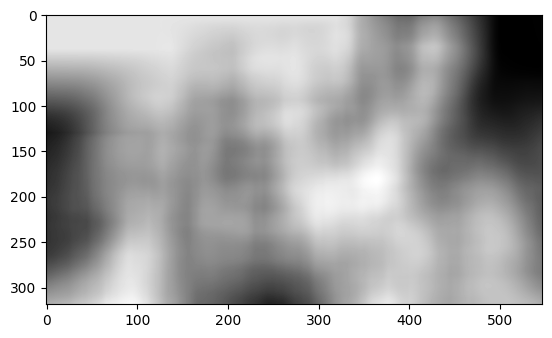

In [ ]:
# visualize
# final_tensor = contrast.squeeze(0).squeeze(0)
# np_image = final_tensor.cpu().detach().numpy()

# plt.imshow(np_image)
# plt.show()

plt.imshow(x_p_minus_x_ap.squeeze(0).squeeze(0).detach().numpy(), cmap='gray')
plt.show()

In [ ]:
print("output1 shape: ", x_p.shape)
print("output2 shape: ", x_ap.shape)
print("Contrast shape: ", x_p_minus_x_ap.shape)
# print("after_maxpooling: ", after_maxpooling.shape)

output1 shape:  torch.Size([1, 319, 547])
output2 shape:  torch.Size([1, 319, 547])
Contrast shape:  torch.Size([1, 319, 547])


In [ ]:
print(x_p_minus_x_ap)

tensor([[[[-23.7858, -24.1421, -24.1421,  ..., -72.0590, -72.0315, -70.9635],
          [-24.0476, -24.4078, -24.4078,  ..., -72.8561, -72.8287, -71.7488],
          [-24.0476, -24.4078, -24.4078,  ..., -72.8620, -72.8348, -71.7550],
          ...,
          [-36.5343, -37.1350, -37.1250,  ..., -36.5225, -36.7058, -36.2649],
          [-36.0909, -36.6813, -36.6720,  ..., -36.2582, -36.4365, -35.9937],
          [-35.5098, -36.0883, -36.0790,  ..., -35.7444, -35.9224, -35.4853]]]])


In [ ]:
x_nz = torch.where(x_p_minus_x_ap > 0.0, x_p_minus_x_ap, torch.tensor(0.0))
print(x_nz.shape)

torch.Size([1, 1, 319, 547])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])


In [ ]:
# Get the non-zero values from final_output
# final_output = final_output.squeeze(0).squeeze(0)
# print(final_output.shape)

In [ ]:
# Get the indices of non zero values
nz_list = torch.nonzero(x_nz)
nz_list

tensor([], size=(0, 4), dtype=torch.int64)

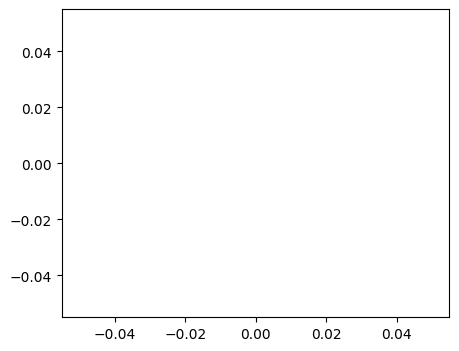

In [ ]:
x = [point[0] for point in nz_list]
y = [point[1] for point in nz_list]
plt.figure(figsize=(5, 4))
plt.scatter(x, y, s = 2, c='r')

In [ ]:
# Make the list of the values of these indices
nz_values = []
for i in range(len(nz_list)):
    x = nz_list[i][1].item()
    y = nz_list[i][0].item()
    nz_values.append(x_p_minus_x_ap[x][y].item())
print(nz_values)

[]


In [ ]:
# Calculate mean and standard deviation
mu = np.mean(nz_values)
sd = np.std(nz_values)
print("mean=",mu)
print("standard deviation=",sd)

mean= nan
standard deviation= nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Threshold
th = mu + sd
print("threshold=", th)

threshold= 3633.2969628401706


In [ ]:
x4 = torch.where(final_output > th, final_output, torch.tensor(0.0))

In [ ]:
x4

tensor([[ 9928.4062, 10039.0596, 10043.2568,  ...,  5128.9541,  5078.6914,
          5001.9678],
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        ...,
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        [ 4908.5908,  4959.2295,  4950.6602,  ...,     0.0000,     0.0000,
             0.0000]])

In [ ]:
# Get max index
index = torch.nonzero(x4)

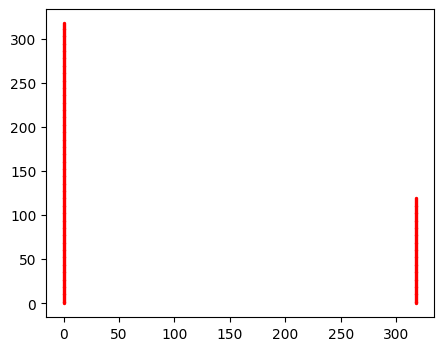

In [ ]:
x = [point[0] for point in index]
y = [point[1] for point in index]
plt.figure(figsize=(5, 4))
plt.scatter(x, y, s = 2, c='r')

In [ ]:
def draw_box(image, coordinate, width, height, color, thickness=1):
    top_left = coordinate
    bottom_right = (top_left[0] + width, top_left[1] + height)
    cv2.rectangle(image, top_left, bottom_right, color, thickness)
    return image

In [ ]:
image = cv2.imread(image_path)
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
height, width, _ = cropped_image.shape
# coordinate = (xmin, ymin)
# image = cv2.rectangle(image, coordinate, (xmin + width, ymin + height), (0, 255, 0), 1)

#  Red color box
for i in range(len(index)):
    xmin2 = indices[i][1].item()
    ymin2 = indices[i][0].item()
    points = (xmin2, ymin2)
    image = cv2.rectangle(image, points, (xmin2 + width, ymin2 + height), (0, 0, 255), 1)


# xmin2 = coordinates[12][1].item()
# ymin2 = coordinates[12][0].item()
# points = (xmin2, ymin2)
# image = cv2.rectangle(image, points, (xmin2 + width, ymin2 + height), (0, 0, 255), 1)

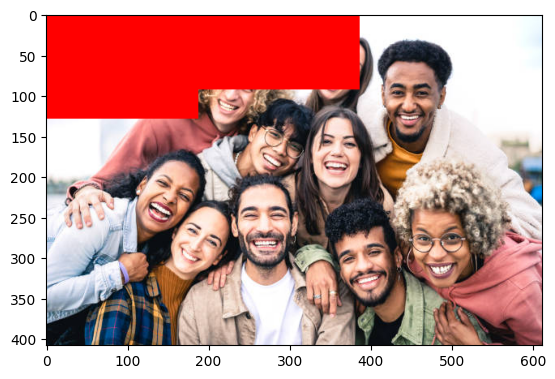

In [ ]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()